In [1]:
# import the required libraries
import numpy as np
import time
import random
import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange
import pickle

# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

In [11]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = 'home/calpeyser/sketch/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

cat_model_dir = "/home/calpeyser/checkpoints/cat/"
dog_model_dir = "/home/calpeyser/checkpoints/dog/"
cat_data_dir = "/home/calpeyser/sketch/data/cat/"
dog_data_dir = "/home/calpeyser/sketch/data/dog/"
flam_model_dir = "/home/calpeyser/sketch/models/flamingo/lstm_uncond"
flam_data_dir = "/home/calpeyser/sketch/data/flamingo/"


INFO:tensorflow:TensorFlow Version: 1.2.1


In [3]:
[cat_train_set, cat_valid_set, cat_test_set, cat_hps_model, cat_eval_hps_model, cat_sample_hps_model] = load_env(cat_data_dir, cat_model_dir)
cat_eval_model = Model(cat_eval_hps_model, reuse=False)
cat_sample_model = Model(cat_sample_hps_model, reuse=True)
[dog_train_set, dog_valid_set, dog_test_set, dog_hps_model, dog_eval_hps_model, dog_sample_hps_model] = load_env(dog_data_dir, dog_model_dir)
dog_eval_model = Model(dog_eval_hps_model, reuse=True)
dog_sample_model = Model(dog_sample_hps_model, reuse=True)


sess = tf.Session()
sess.run(tf.global_variables_initializer())

INFO:tensorflow:Loaded 70000/2500/2500 from cat.npz
INFO:tensorflow:Dataset combined: 75000 (70000/2500/2500), avg len 69
INFO:tensorflow:model_params.max_seq_len 129.
total images <= max_seq_len is 70000
total images <= max_seq_len is 2500
total images <= max_seq_len is 2500
INFO:tensorflow:normalizing_scale_factor 43.1702.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Loaded 70000/2500/2500 from dog.npz
INFO:tensorflow:Dataset combined: 75000 (70000/2500/2500), avg len 75
INFO:tensorflow:model_params.max_seq_len 133.
total images <= max_seq_len is 70000
total images <= max_seq_len is 2500
total images <= max_seq_len is 2500
INFO:tensorflow:normalizing_scale_factor 38.4734.
INFO:tensorflow:Model using gp

In [20]:
def encode(eval_model, input_strokes, max_len=129):
  strokes = to_big_strokes(input_strokes, max_len=max_len).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  #draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]
def decode(eval_model, sample_model, z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  return strokes

In [5]:
load_checkpoint(sess, cat_model_dir)
cat = cat_test_set.random_sample()
print(cat.shape)
encoding = encode(cat_eval_model, cat)
decoding = decode(cat_eval_model, cat_sample_model, encoding)

draw_strokes(cat)
print(encoding)
draw_strokes(decoding)
 

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500
(74, 3)
[ 1.4599313   0.65149516  1.1183821  -0.60878444  1.3521897   0.11855504  1.6480156   0.6382079   1.1354936  -0.36940917 -1.1167897  -0.9457218   0.6131381  -0.19298363  2.4699497  -1.2040303
  1.7374122  -0.37075922  1.577292   -0.02854326  0.7033927  -1.7714503  -0.8213583   1.3244804   0.20628504  0.44805786 -0.58115643  0.57862705  0.7134656  -0.4404264   0.4172904   1.4601276
 -0.0072885  -2.2187045  -1.1009058   0.01405858  0.47865894  0.13156521  0.85095453 -1.8364269  -0.54644173  0.17570168 -2.3392935  -0.94112766  1.0847248  -0.6018719  -0.9924684  -0.27448192
 -0.4424341   1.7577163  -0.560391   -0.5958836   1.3415551  -0.9036122  -0.8066884   0.1763548   0.7905827   1.2818584   1.769429    1.203796   -0.07239371  0.9895247   0.38958654 -0.36984605
 -0.9602379   0.5785717   1.3224053   0.22519371  0.2212061

In [ ]:
# Generate dataset
for i in range(1000):
    draw_strokes(cat_train_set.strokes[i], svg_filename="/home/calpeyser/sketch/sketches/cat/" + str(i) + ".svg")
    if (i % 100 == 0):
        print(i)

In [25]:
# Obtain traning data from manually labeled dataset
"""
# Manually labeled pairs - not using these right now
labels = [(264,432),
(278,441),
(528,196),
(517,311),
(525,281),
(642,441),
(651,345),
(531,383),
(533,381),
(618,432),
(814,511),
(839,378),
(565,443),
(553,505),
(706,641),
(913,0),
(137,1),
(251,2),
(711,8),
(243,230),
(451,220),
(832,632),
(984,307),
(944,352),
(593,307),
(21,389)]
"""

DOG_NO_FEATURE_IND = [49,64,205,221,222,248,282,283,378,425,441,443,459,500,613,607,619,713,747,791]
DOG_FEATURES_IND = [3,26,41,73,92,167,177,196,311,329,383,398,587,639,689,743,787,792,829,877]
DOG_BODY_IND = [0,1,2,8,9,11,337,343,352,364,367,388,446,467,479,492,494,504,518,552]

category_labels = {
    "cat": {
        "no_features": [3,4,17,23,65,66,106,152,205,236,239,240,304,322,325,344,369,381,382,394],
        "features": [2,7,8,9,10,15,16,19,20,26,28,30,35,46,188,204,208,228,434,657],
        "body": [12,21,177,112,332,659,714,697,0,1,129,696,552,659,692,781,787,833,866,944],
    },
    "dog": {
        "no_features": DOG_NO_FEATURE_IND,
        "features": DOG_FEATURES_IND,
        "body": DOG_BODY_IND,
    }
}
"""
# An alternative possible labeling
category_labels = {
    "cat": {
        "whiskers": [16,25,34,51,53,80,82,130,156,192,291,292,305,327,333,375,417,422,440,478,489,577,594,654,704,898,940,957],
        "no_whiskers": [3,4,17,19,23,29,33,65,66,90,106,114,152,186,218,228,253,278,279,283,284,288,290,295,296,335,338,334,360,369],
    },
    "dog": {
        "body": [0,1,2,8,9,11,337,343,352,364,367,388,446,467,479,492,494,504,518,552],
        "face": [49,64,205,221,222,248,282,283,378,425,3,26,41,73,92,167,177,196,311],
    }
}
"""


# load cat model, map sketches onto embeddings
load_checkpoint(sess, cat_model_dir)

category_labels["cat"]["no_features"] = [encode(cat_eval_model, cat_train_set.strokes[i]) for i in category_labels["cat"]["no_features"]]
category_labels["cat"]["features"] = [encode(cat_eval_model, cat_train_set.strokes[i]) for i in category_labels["cat"]["features"]]
category_labels["cat"]["body"] = [encode(cat_eval_model, cat_train_set.strokes[i]) for i in category_labels["cat"]["body"]]


# load dog model, map sketches onto embeddings
load_checkpoint(sess, dog_model_dir)

category_labels["dog"]["no_features"] = [encode(dog_eval_model, dog_train_set.strokes[i], max_len=133) for i in category_labels["dog"]["no_features"]]
category_labels["dog"]["features"] = [encode(dog_eval_model, dog_train_set.strokes[i], max_len=133) for i in category_labels["dog"]["features"]]
category_labels["dog"]["body"] = [encode(dog_eval_model, dog_train_set.strokes[i], max_len=133) for i in category_labels["dog"]["body"]]


INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


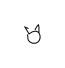

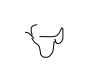

---------


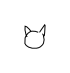

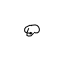

---------


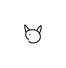

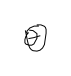

---------


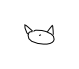

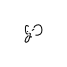

---------


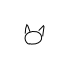

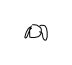

---------


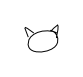

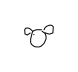

---------


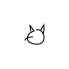

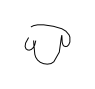

---------


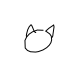

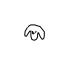

---------


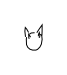

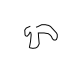

---------


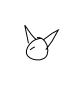

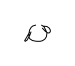

---------


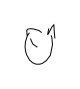

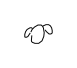

---------


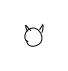

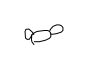

---------


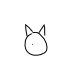

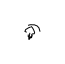

---------


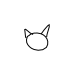

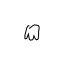

---------


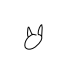

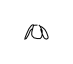

---------


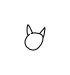

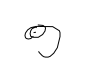

---------


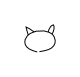

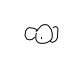

---------


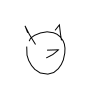

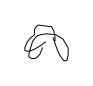

---------


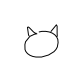

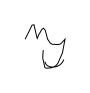

---------


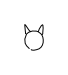

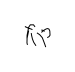

---------


In [12]:
# Sanity check labels
cats = []
dogs = []

# Decode cats
load_checkpoint(sess, cat_model_dir)
for cat in category_labels["cat"]["no_features"]:
    decoding = decode(cat_eval_model, cat_sample_model, cat)
    cats.append(decoding)
    
# Decode dogs
load_checkpoint(sess, dog_model_dir)
for dog in category_labels["dog"]["no_features"]:
    decoding = decode(dog_eval_model, dog_sample_model, dog)
    dogs.append(decoding)
    
for cat, dog in zip(cats, dogs):
    draw_strokes(cat)
    draw_strokes(dog)
    print("---------")


In [39]:
# Compute average variance across data
all_data = []
all_data.extend(category_labels["cat"]["no_features"])
all_data.extend(category_labels["cat"]["features"])
all_data.extend(category_labels["cat"]["body"])
all_data.extend(category_labels["dog"]["no_features"])
all_data.extend(category_labels["dog"]["features"])
all_data.extend(category_labels["dog"]["body"])


variances = np.var(all_data, axis=0)
print(variances.shape)


(128,)


In [40]:
# Train a linear model on the sketch labels
STARTER_LEARNING_RATE = 0.04
EXAMPLE_COUNT = 20000

linear_graph = tf.Graph()
with linear_graph.as_default():
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(STARTER_LEARNING_RATE, global_step, 4000, 0.96, staircase=True)

    # Constant - MSE weights
    MSE_weight = tf.constant(variances)
    
    # TF graph input
    X = tf.placeholder("float64")
    Y = tf.placeholder("float64")

    # TF weights
    W_x_to_y = tf.Variable(np.random.rand(128), name = "linear_model_weight_x_to_y")
    b_x_to_y = tf.Variable(np.random.rand(128), name = "linear_model_bias_x_to_y")
    W_y_to_x = tf.Variable(np.random.rand(128), name = "linear_model_weight_y_to_x")
    b_y_to_x = tf.Variable(np.random.rand(128), name = "linear_model_bias_y_to_x")

    prediction_x_to_y = tf.add(tf.multiply(X, W_x_to_y), b_x_to_y)
    prediction_y_to_x = tf.add(tf.multiply(X, W_y_to_x), b_y_to_x)
    
    cost = tf.losses.mean_squared_error(Y, prediction_x_to_y, weights=MSE_weight) + tf.losses.mean_squared_error(X, prediction_y_to_x, weights=MSE_weight)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost, global_step=global_step)

    init = tf.variables_initializer([W_x_to_y, b_x_to_y, W_y_to_x, b_y_to_x, global_step])

linear_model_sess = tf.Session(graph=linear_graph)
linear_model_sess.run(init)
costs = []
for example_num in range(EXAMPLE_COUNT):
    category = ["features", "no_features", "body"][random.randint(0,2)] # choose a random category
    # Choose a cat and dog in the given category at random
    cat = category_labels["cat"][category][random.randint(0, len(category_labels["cat"][category]) - 1)]
    dog = category_labels["dog"][category][random.randint(0, len(category_labels["dog"][category]) - 1)]
    
    _, cost_ = linear_model_sess.run([optimizer, cost], feed_dict={X: dog, Y: cat})
    costs.append(cost_)
    
    if (example_num % 1000) == 0:
        cost_computed = sum(costs)/len(costs)
        costs = []
        print("Example: %s, Cost: %s " % (example_num, cost_computed))



Example: 0, Cost: 2.09010648727417 
Example: 1000, Cost: 1.6624650794267655 
Example: 2000, Cost: 1.158080113351345 
Example: 3000, Cost: 1.0017779984474182 
Example: 4000, Cost: 0.9559418302178383 
Example: 5000, Cost: 0.938061214864254 
Example: 6000, Cost: 0.9329511366486549 
Example: 7000, Cost: 0.9257610821127892 
Example: 8000, Cost: 0.9240656213760376 
Example: 9000, Cost: 0.9265393778085709 
Example: 10000, Cost: 0.923055458009243 
Example: 11000, Cost: 0.9280023540258407 
Example: 12000, Cost: 0.9218076238632202 
Example: 13000, Cost: 0.9269023779034614 
Example: 14000, Cost: 0.9252893818616867 
Example: 15000, Cost: 0.9281752435564995 
Example: 16000, Cost: 0.9171215321421623 
Example: 17000, Cost: 0.9258781738877296 
Example: 18000, Cost: 0.9211657215356827 
Example: 19000, Cost: 0.9253408387303352 


49
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


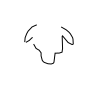

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


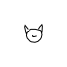

------------------
64
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


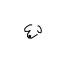

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


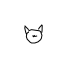

------------------
205
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


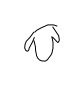

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


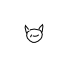

------------------
221
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


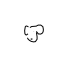

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


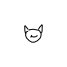

------------------
222
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


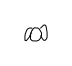

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


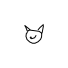

------------------
248
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


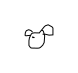

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


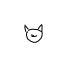

------------------
282
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


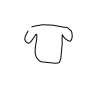

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


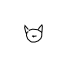

------------------
283
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


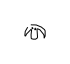

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


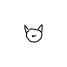

------------------
378
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


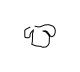

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


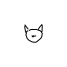

------------------
425
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


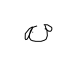

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


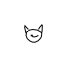

------------------
441
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


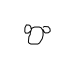

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


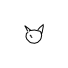

------------------
443
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


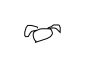

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


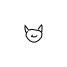

------------------
459
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


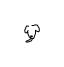

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


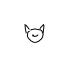

------------------
500
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


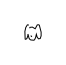

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


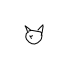

------------------
613
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


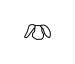

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


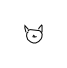

------------------
607
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


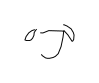

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


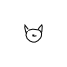

------------------
619
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


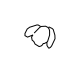

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


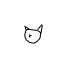

------------------
713
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


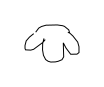

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


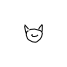

------------------
747
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


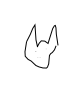

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


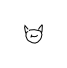

------------------
791
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


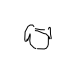

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


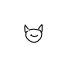

------------------


In [42]:
# Lets do some predictions - we'll start with "no_features"
def convert(dog_ind):
    load_checkpoint(sess, dog_model_dir)
    dog = dog_train_set.strokes[dog_ind]
    draw_strokes(dog)
    encoding = encode(dog_eval_model, dog, max_len=133)
    #draw_strokes(decode(dog_eval_model, dog_sample_model, encoding))
    predicted_encoding = linear_model_sess.run(prediction_x_to_y, feed_dict = {X: encoding})
    load_checkpoint(sess, cat_model_dir)
    decoding = decode(cat_eval_model, cat_sample_model, predicted_encoding)
    draw_strokes(decoding)
    print "------------------"

for i in DOG_NO_FEATURE_IND:
    print(i)
    convert(i)

3
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


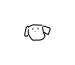

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


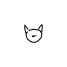

26
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


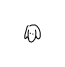

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


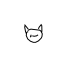

41
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


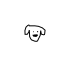

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


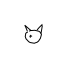

73
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


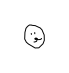

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


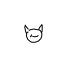

92
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


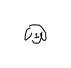

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


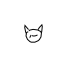

167
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


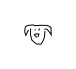

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


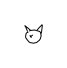

177
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


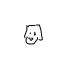

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


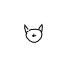

196
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


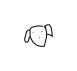

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


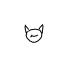

311
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


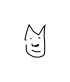

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


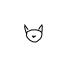

329
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


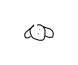

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


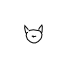

383
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


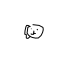

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


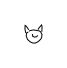

398
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


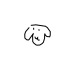

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


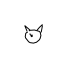

587
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


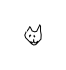

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


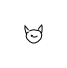

639
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


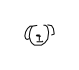

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


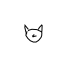

689
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


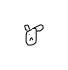

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


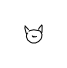

743
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


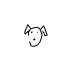

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


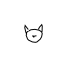

787
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


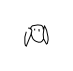

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


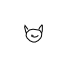

792
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


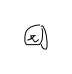

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


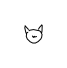

829
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


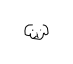

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


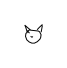

877
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


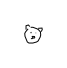

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


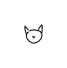

In [31]:
# Now, "features"
for i in DOG_FEATURES_IND:
    print(i)
    convert(i)


0
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


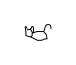

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


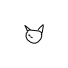

------------------
1
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


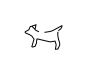

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


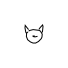

------------------
2
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


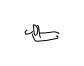

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


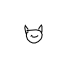

------------------
8
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


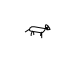

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


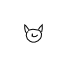

------------------
9
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


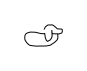

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


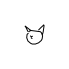

------------------
11
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


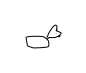

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


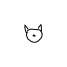

------------------
337
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


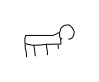

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


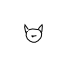

------------------
343
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


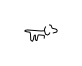

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


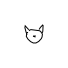

------------------
352
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


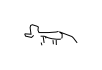

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


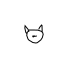

------------------
364
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


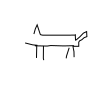

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


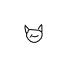

------------------
367
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


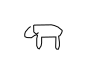

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


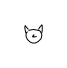

------------------
388
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


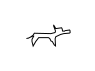

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


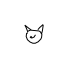

------------------
446
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


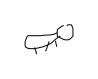

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


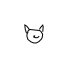

------------------
467
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


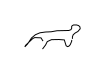

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


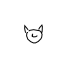

------------------
479
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


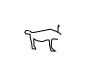

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


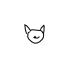

------------------
492
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


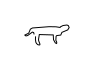

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


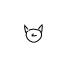

------------------
494
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


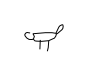

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


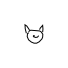

------------------
504
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


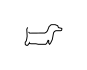

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


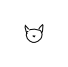

------------------
518
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


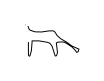

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


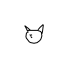

------------------
552
INFO:tensorflow:Loading model /home/calpeyser/checkpoints/dog/vector-41500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/dog/vector-41500


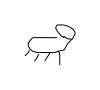

INFO:tensorflow:Loading model /home/calpeyser/checkpoints/cat/vector-47500.
INFO:tensorflow:Restoring parameters from /home/calpeyser/checkpoints/cat/vector-47500


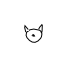

------------------


In [43]:
# Now, "body"
for i in DOG_BODY_IND:
    print(i)
    convert(i)